# Try A
In this trial, we will see whether the transformed Mel-spectrogram can be restored to audio. 

In [88]:
from paths import *
import torch
import torchaudio
import torch.nn as nn
from IPython.display import Audio

In [89]:
rec_dir = train_cut_phone_

In [90]:
phone_path = os.path.join(rec_dir, '103/1240/0001/103-1240-0001-0133.flac')

In [91]:
S_data, sample_rate_S = torchaudio.load(phone_path, normalize=True)

In [92]:
Audio(S_data.numpy()[0], rate=sample_rate_S)

## Make it go through transformation

In [93]:
from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import Normalizer, DeNormalizer, TokenMap, WordDictionary
import matplotlib.pyplot as plt

REC_SAMPLE_RATE = 16000
N_FFT = 1024
N_MELS = 128

In [128]:
class MelSpecTransformDB(nn.Module): 
    def __init__(self, sample_rate, n_fft=400, n_mels=64, normalizer=None, denormalizer=None): 
        super().__init__()
        self.sample_rate = sample_rate
        hop_length = int((n_fft//2 + 1))
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, f_max=sample_rate//2)
        self.inverse_mel = torchaudio.transforms.InverseMelScale(sample_rate=sample_rate, n_mels=n_mels, n_stft=hop_length, f_max=sample_rate//2)
        self.grifflim = torchaudio.transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)
        self.amplitude_to_DB = torchaudio.transforms.AmplitudeToDB(stype='power')

        self.normalizer = normalizer
        self.denormalizer = denormalizer

    def forward(self, waveform): 
        # transform to mel_spectrogram
        mel_spec = self.transform(waveform)  # (channel, n_mels, time)
        # mel_spec = F.amplitude_to_DB(mel_spec)
        mel_spec = self.amplitude_to_DB(mel_spec)
        # mel_spec = torch.tensor(librosa.power_to_db(mel_spec.squeeze().numpy()))
        mel_spec = mel_spec.squeeze()
        mel_spec = mel_spec.permute(1, 0) # (F, L) -> (L, F)
        mel_spec = self.normalizer(mel_spec)
        return mel_spec
    
    def de_norm(self, this_mel_spec, waveform): 
        # transform to mel_spectrogram
        mel_spec = self.transform(waveform)  # (channel, n_mels, time)
        # mel_spec = torch.tensor(librosa.power_to_db(mel_spec.squeeze().numpy()))
        mel_spec = self.amplitude_to_DB(mel_spec)
        mel_spec = mel_spec.squeeze()
        mel_spec = mel_spec.permute(1, 0) # (F, L) -> (L, F)
        this_mel_spec = self.denormalizer(this_mel_spec, mel_spec)
        return this_mel_spec
    
    def inverse(self, mel_spec): 
        mel_spec = mel_spec.permute(1, 0) # (L, F) -> (F, L)
        # mel_spec = torch.tensor(librosa.db_to_power(mel_spec.numpy()))
        mel_spec = torchaudio.functional.DB_to_amplitude(mel_spec, ref=1.0, power=1)
        mel_spec = mel_spec.unsqueeze(0)  # restore from (F, L) to (channel, F, L)
        i_mel = self.inverse_mel(mel_spec)
        inv = self.grifflim(i_mel)
        return inv

In [136]:
mytrans = MelSpecTransformDB(sample_rate=REC_SAMPLE_RATE, 
                    n_fft=2048, n_mels=N_MELS, 
                    normalizer=Normalizer.norm_mvn, 
                    denormalizer=DeNormalizer.norm_mvn)

In [137]:
norm_S_data = mytrans(S_data)

In [138]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontdict={"fontsize": 18})
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

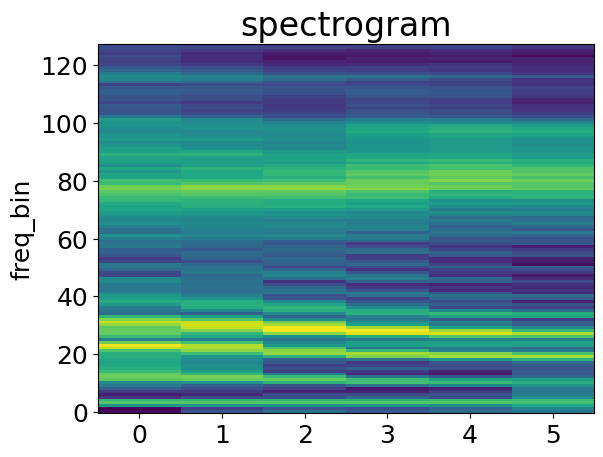

In [139]:
plot_spectrogram(norm_S_data.T, title="spectrogram")

In [140]:
denorm_S_data = mytrans.de_norm(norm_S_data, S_data)

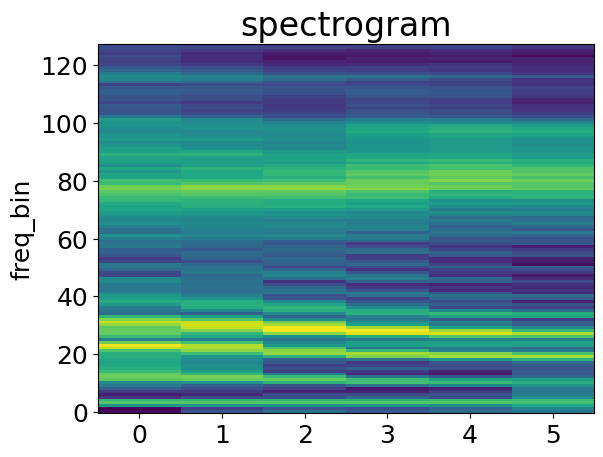

In [141]:
plot_spectrogram(denorm_S_data.T, title="spectrogram")

In [142]:
reconaudio = mytrans.inverse(denorm_S_data)

RuntimeError: istft(CPUComplexFloatType[1, 512, 6], n_fft=2048, hop_length=512, win_length=2048, window=torch.FloatTensor{[2048]}, center=1, normalized=0, onesided=None, length=None, return_complex=0) : expected the frequency dimension (3rd to the last) of the input tensor to match n_fft / 2 + 1 when onesided=True, but got 512

In [119]:
Audio(reconaudio.numpy()[0], rate=sample_rate_S)